# Simulations of the spread of a disease through nearest-neighbors interactions

[Index](../0-index.ipynb)

We solve the SIR dynamics on a 2d lattice with nearest-neighbors interaction in the script [9-lattice_2d_nneighbors_exec.py](9-lattice_2d_nneighbors_exec.py). We analyze the simulations in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import cupy as cp
import pandas as pd
import h5py
import datetime
import scipy
import imageio

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('..') / 'code'))
from functions import wave_front_get_ode_sol, get_residual_susceptible, lattice_2d_plot_position, lattice_2d_plot_profile

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'lattice_2d_nneighbors.hdf5'
complevel=7
complib='zlib'
# if resfile.is_file():
#     with h5py.File(resfile,'r') as f5py:
#         f5py.visit(print)

## Parameters

In [6]:
N1 = 1024
N2 = 256
pref = "N{:d}_M{:d}".format(N1,N2)
gamma_real = 0.1
istart = int(0.1*N1)     # start plot from this site (avoid boundary effects)

dpi=300
exts = ['.png', '.svg']

In [7]:
gamma_list = [0.8, 0.4, 0.2, 0.1]
beta_list = [gamma_real / (5.*g) for g in gamma_list]
n_list = len(gamma_list)
print(gamma_list)
print(beta_list)

[0.8, 0.4, 0.2, 0.1]
[0.025, 0.05, 0.1, 0.2]


In [8]:
times_list = []
S_tot_list = []
I_tot_list = []
Sm_list = []
Im_list = []

for n in range(n_list):
    beta = beta_list[n]
    gamma = gamma_list[n]
    
    # load results
    path = str(Path(pref) / "gamma_{:.2e}".format(gamma))
    with h5py.File(resfile,'r') as f5py:
        if not (path in f5py.keys()):
            raise ValueError("{:s} not in the database".format(path))
        grp = f5py[path]

    #     print(grp.keys())
        name = "times"
        times = grp[name][:]

        name = "susceptible"
        Ss = grp[name][:]

        name = "infected"
        Is = grp[name][:]

    S_tot = np.mean(Ss, axis=(1,2))
    I_tot = np.mean(Is, axis=(1,2))

    if N2 == 1:
        midline = [0]
    else:
        midline = [N2//2-1,N2//2]
    Sm = np.mean(Ss[:,:,midline], axis=2)
    Im = np.mean(Is[:,:,midline], axis=2)
   
    times_list.append(times)
    S_tot_list.append(S_tot)
    I_tot_list.append(I_tot)
    Sm_list.append(Sm)
    Im_list.append(Im)

Compute final state to define position of the front

In [9]:
sinf_list = np.array([get_residual_susceptible(gamma_tilde) for gamma_tilde in gamma_list])
mass_list = 0.5*(sinf_list+1.)

## Compute theoretical wave shapes

In [10]:
solution_list = []
eps = 5.0e-4

for n in range(n_list):
    gamma = gamma_list[n]
    # determine final nu
    sinf = sinf_list[n]
    xinf = -np.log(sinf)

    # construct an initial condition for the ODE
    feps = 1.0e-5
    while True:
        sf = np.exp(-(xinf - feps))
        jf = 1. - gamma*(xinf - feps)-sf
        if (gamma/(2.*np.sqrt(1-gamma))*jf > eps):
            break
        else:
            feps *= 3.
    print("s_inf = {:.4e}    s_f = {:.4e}    j_f = {:.4e}".format(sinf, sf, jf))

#     gamma/(2.*np.sqrt(1-gamma))*jf
    X0 = np.array([0.,jf,sf])
    
    # solve the ODE
    Z, S, I, S_der = wave_front_get_ode_sol(X0, gamma, npts=10000, zmax=1000, eps=1.0e-8, method='BDF')
    
    # center
    i0 = np.argmin(np.abs(S-0.5*(sinf+1.)))
    z0 = Z[i0]
    Z = Z-z0
    
    # add to list
    solution_list.append(np.array([Z, S, I]))

s_inf = 6.2863e-01    s_f = 6.3323e-01    j_f = 1.2325e-03
s_inf = 1.0736e-01    s_f = 1.0814e-01    j_f = 2.1305e-03
s_inf = 6.9772e-03    s_f = 7.4503e-03    j_f = 1.2649e-02
s_inf = 4.5421e-05    s_f = 5.5301e-05    j_f = 1.9673e-02


## Figures

In [11]:
figdir = Path('..') / 'figures' / '9-lattice_2d_nneighbors'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)
print(figdir)

../figures/9-lattice_2d_nneighbors


### Wave profile and position

In [12]:
for n in range(n_list):
    fname = "wave_position_susceptible_beta{:.3f}".format(beta_list[n])
    for ext in exts:
        filepath = figdir / (fname + ext)
        lattice_2d_plot_profile(times_list[n], Sm_list[n][:,istart:], idump=200, ylabel='S', mass=mass_list[n], fileout=filepath, cmap=cm.viridis)
        
    fname = "wave_position_infected_beta{:.3f}".format(beta_list[n])
    for ext in exts:
        filepath = figdir / (fname + ext)
        lattice_2d_plot_profile(times_list[n], Im_list[n][:,istart:], idump=200, ylabel='I', mass=1, fileout=filepath, cmap=cm.viridis)

../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.025.png
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.025.svg
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.025.png
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.025.svg
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.050.png
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.050.svg
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.050.png
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.050.svg
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.100.png
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.100.svg
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.100.png
../figures/9-lattice_2d_nneighbors/wave_position_infected_beta0.100.svg
../figures/9-lattice_2d_nneighbors/wave_position_susceptible_beta0.200.png
../figures/9-lattice_2d_nneighbors/wave_pos

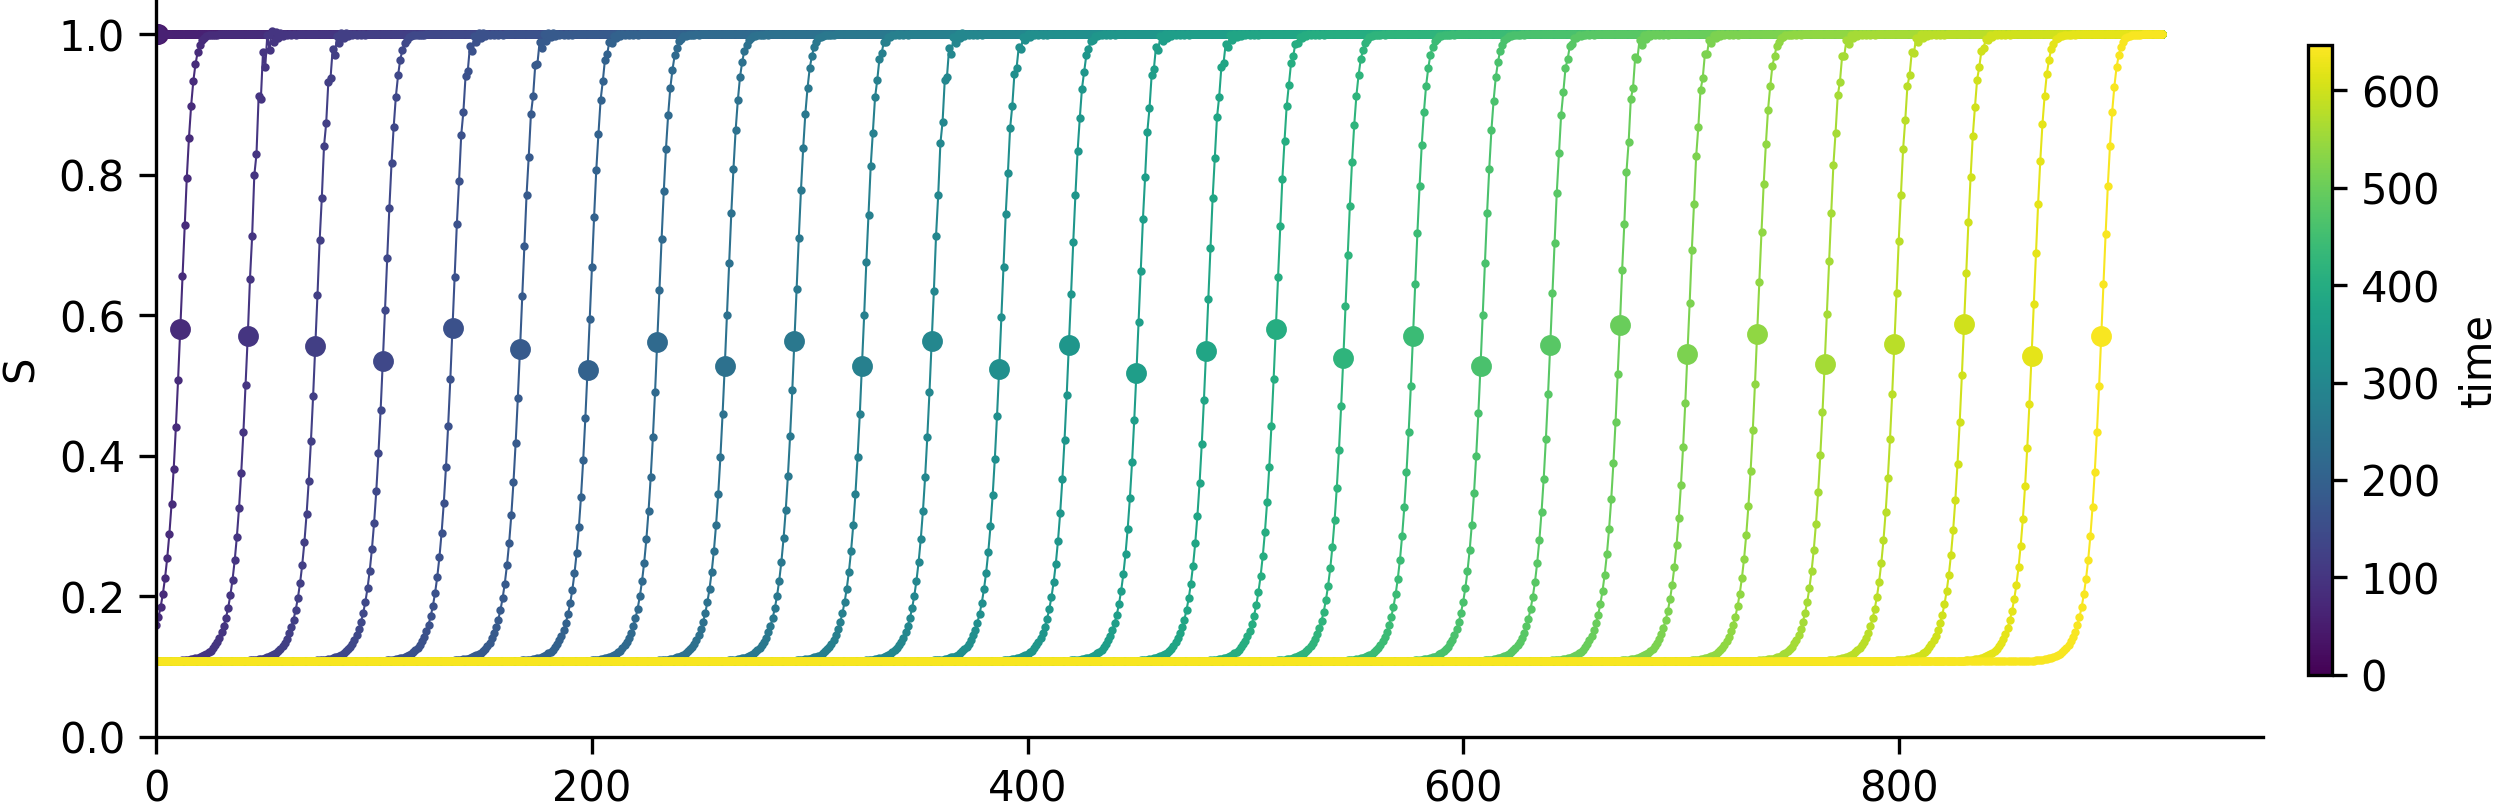

In [13]:
n = 1
filepath = figdir / ("wave_position_susceptible_beta{:.3f}".format(beta_list[n]) + '.png')
Image(filename=filepath, width=4./3*360)

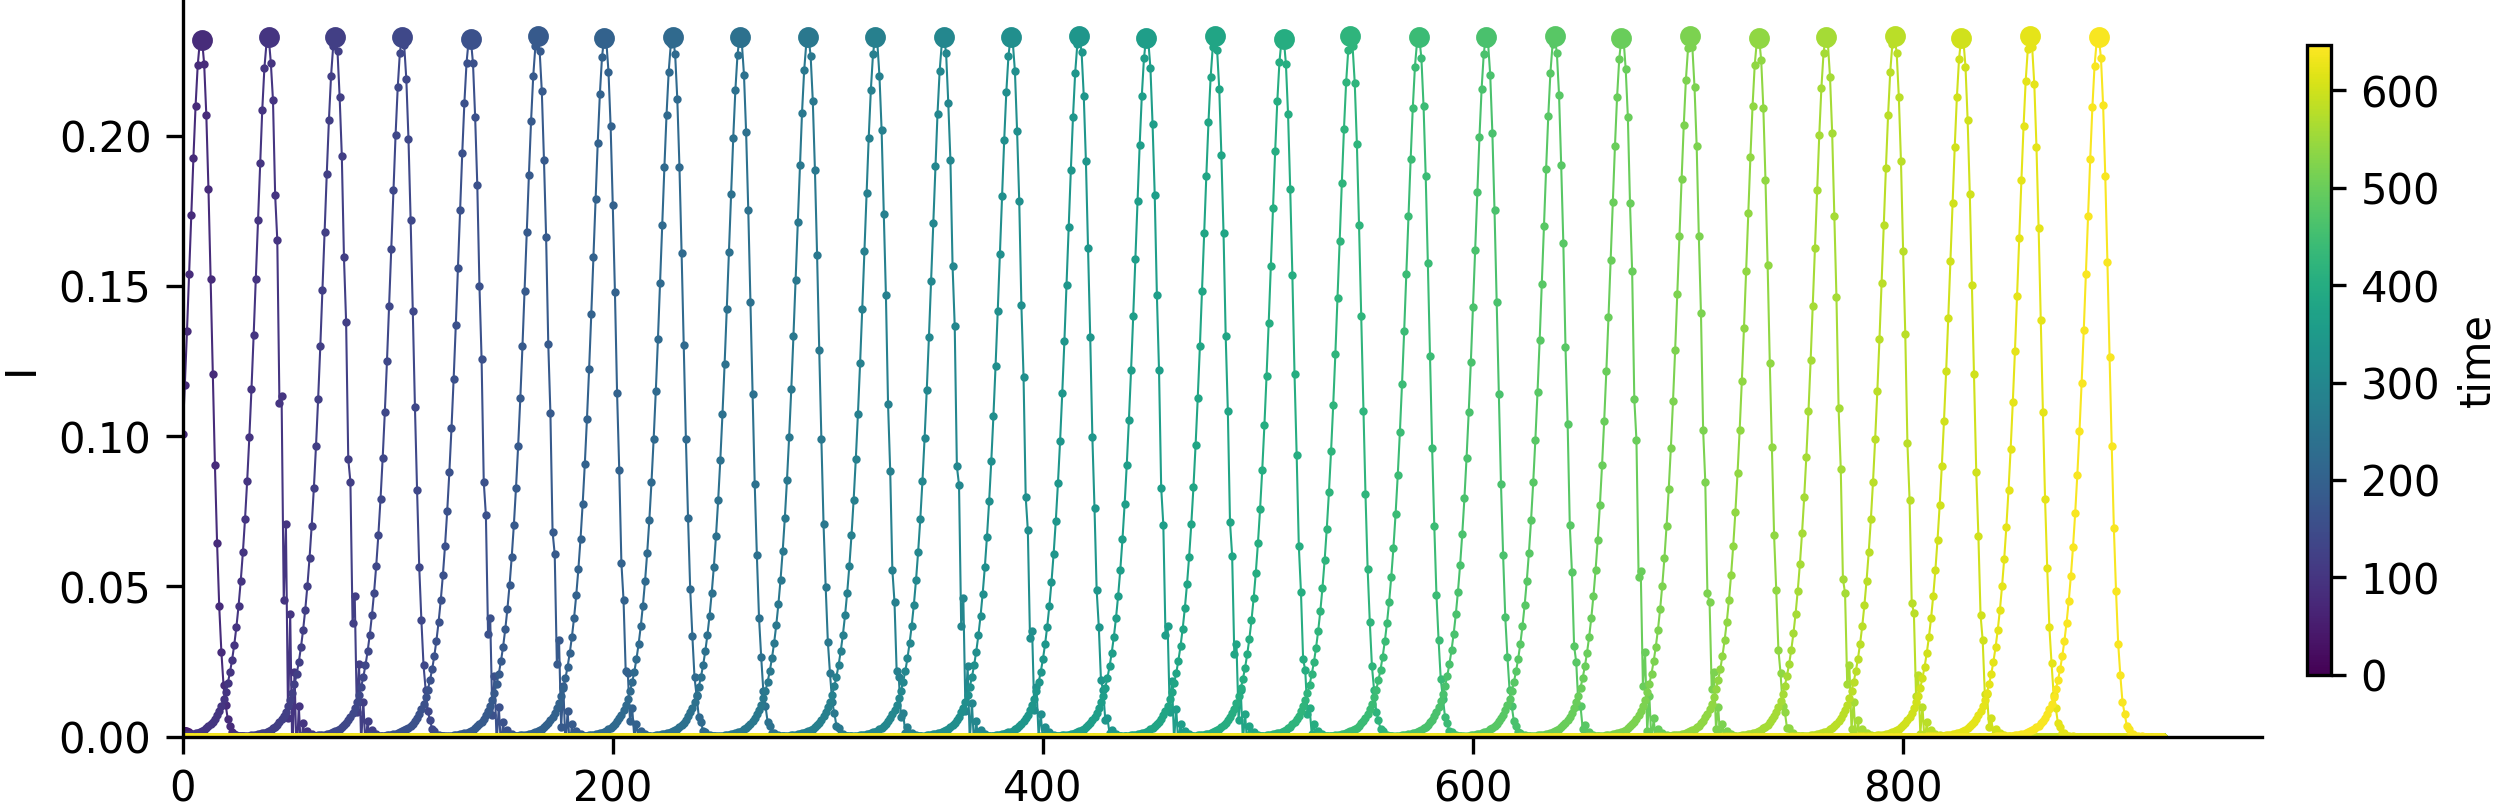

In [14]:
filepath = figdir / ("wave_position_infected_beta{:.3f}".format(beta_list[n]) + '.png')
Image(filename=filepath, width=4./3*360)

In [15]:
for ext in exts:
    filepath = figdir / ("wave_position" + ext)
    lattice_2d_plot_position(times_list, [Sm[:, istart:] for Sm in Sm_list], mass=0.5*(sinf_list+1.), fileout=filepath)

../figures/9-lattice_2d_nneighbors/wave_position.png
../figures/9-lattice_2d_nneighbors/wave_position.svg


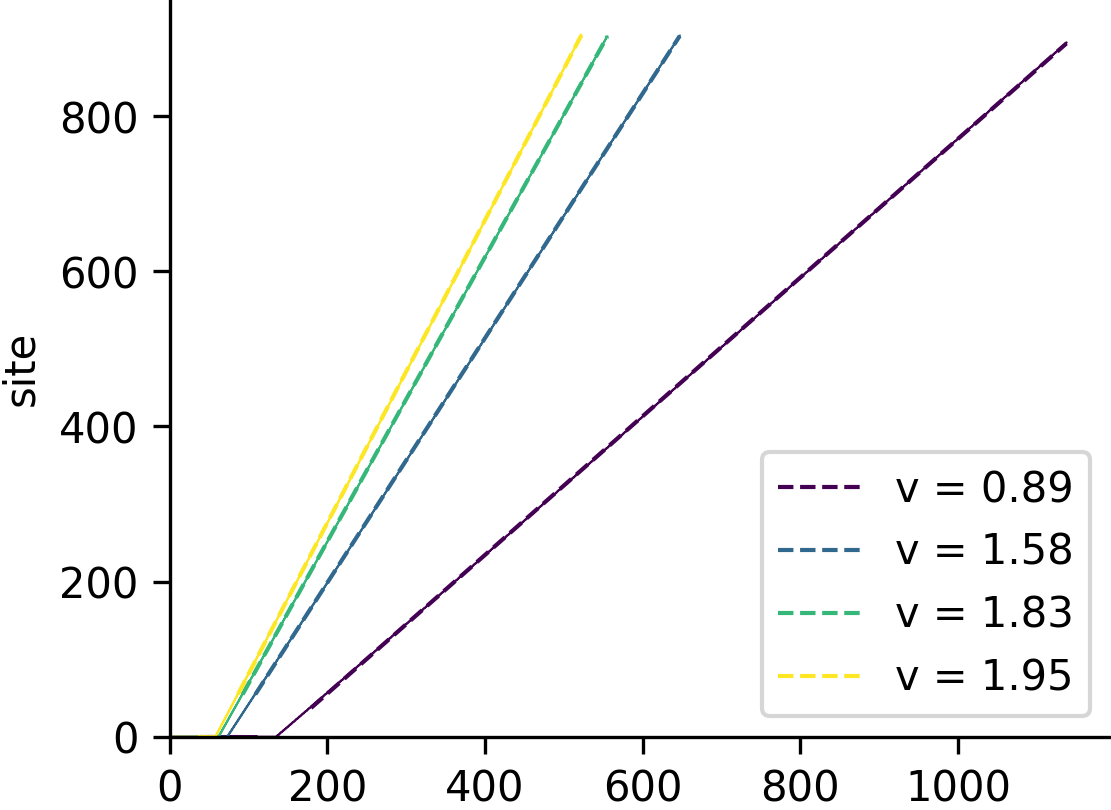

In [16]:
filepath = figdir / ("wave_position" + '.png')
Image(filename=filepath, width=4./3*360)

### Fit to analytical prediction

In [17]:
figsize=(4,3)
norm = mco.Normalize(vmin=0, vmax=n_list-1)
cmap = cm.rainbow
zmin = -150
zmax = 150
# tplot = 300
# kplot = int(tplot/tdump)


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()
for n in range(n_list):
    kplot = int(0.9*len(times))
    gamma_tilde = gamma_list[n]
    beta = beta_list[n]
    times = times_list[n]
    color = cmap(norm(n))
    kplot = int(0.9*len(times))
    label = "beta = {:.3f}".format(beta)
    
    Sm = Sm_list[n][kplot, istart:]
    Im = Im_list[n][kplot, istart:]
    Z = np.arange(N1, dtype=np.float_)[istart:]
    
    # center
    i0 = np.argmin(np.abs(Sm-mass_list[n]))
    z0 = Z[i0]
    Z = Z-z0
    
    # plots
    ax.plot(Z, Im, 'o', color=color, ms=2)
    
    # theory
    Z, S, I = solution_list[n]
    ax.plot(Z, I, '-', color=color, lw=0.5, label=label)
    
ax.set_xlim(zmin,zmax)
# ax.set_ylim(0., 1)
ax.legend(loc='upper left', fontsize='medium', frameon=False)
ax.set_xlabel("z", fontsize="medium")
ax.set_ylabel("I", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'profile_collapse_fit'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/9-lattice_2d_nneighbors/profile_collapse_fit.png
Written file: ../figures/9-lattice_2d_nneighbors/profile_collapse_fit.svg


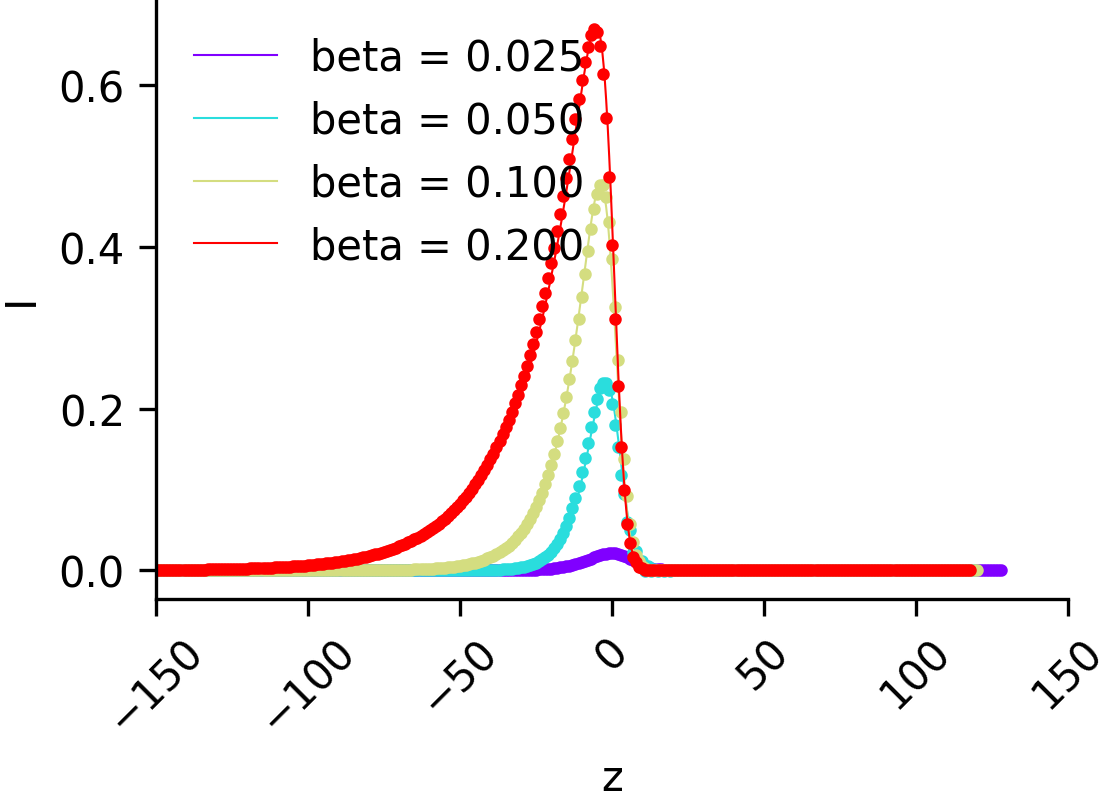

In [18]:
filepath = figdir / ("profile_collapse_fit" + '.png')
Image(filename=filepath, width=4./3*360)

## Show (S,I,R) profiles

In [19]:
bfmt = "{:.2f}"
outdir = figdir / 'profile_sir'
if not outdir.is_dir():
    outdir.mkdir(exist_ok=True)

for n in range(len(beta_list)):
    beta = beta_list[n]
    times = times_list[n]

    title = "beta = " + bfmt.format(beta)

    Z, S, I = solution_list[n]
    R = 1. - S - I

    fig = plt.figure(figsize=(4,3), dpi=300)
    ax = fig.gca()
    ax.plot(Z, S, '-', lw=1, color='darkblue', label='S')
    ax.plot(Z, I, '-', lw=1, color='red', label='I')
    ax.plot(Z, R, '-', lw=1, color='darkorange', label='R')
    ax.legend(loc='best', fontsize='medium')

    ax.set_title(title, fontsize='medium')
    ax.set_ylim(0., 1)
    ax.set_xlabel("Z", fontsize="medium")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
    ax.tick_params(axis='both', length=4)
    fig.tight_layout(rect=[0., 0., 0.98, 1.])

    fname = 'profile_sir_beta' + bfmt.format(beta)
    for ext in exts:
        filepath = outdir / (fname + ext)
        fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
        print("Written file: {:s}".format(str(filepath)))
    fig.clf()
    plt.close('all')

Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.03.png
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.03.svg
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.05.png
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.05.svg
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.10.png
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.10.svg
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.20.png
Written file: ../figures/9-lattice_2d_nneighbors/profile_sir/profile_sir_beta0.20.svg


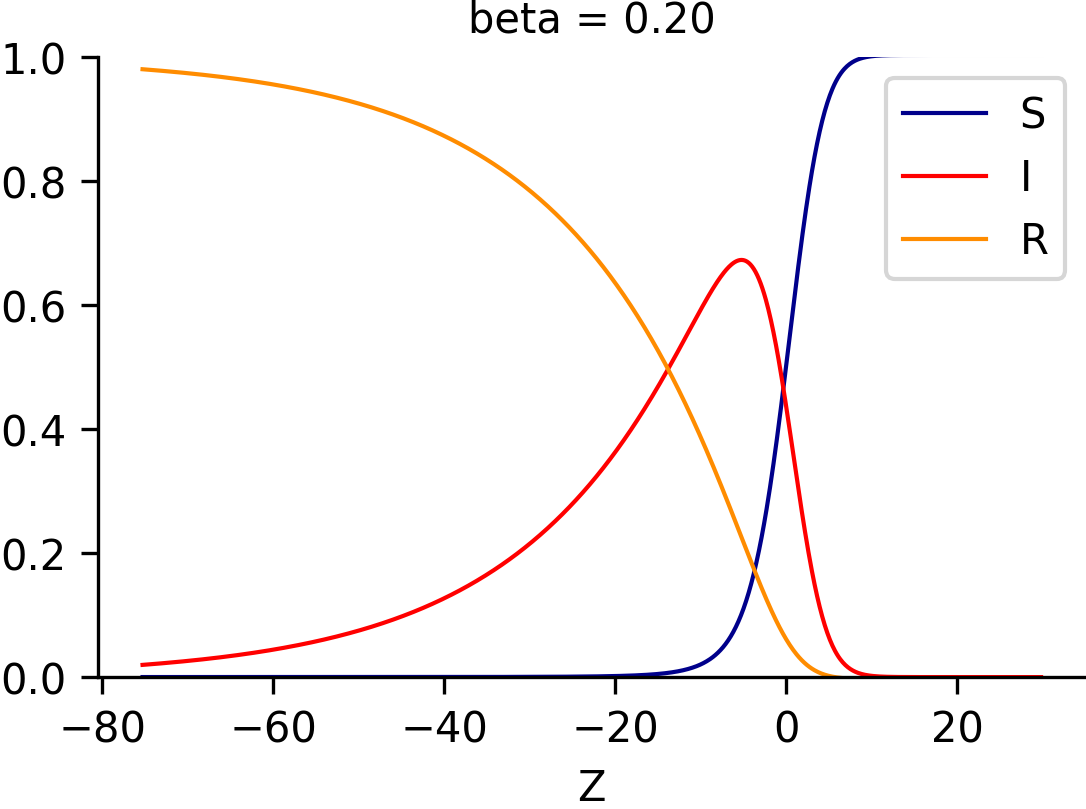

In [20]:
n = 3
beta = beta_list[n]
fname = 'profile_sir_beta' + bfmt.format(beta)
filepath = outdir / (fname + '.png')
Image(filename=filepath, width=4./3*480)

## Wave animation

In [21]:
fps = 30
duration = 10
nframes = duration*fps
dpi=300
outputdir = figdir / '2d_plots' / 'N{:d}_M{:d}'.format(N1,N2)
fig_h = 720
fig_w = (float(N1)/N2)*fig_h
fig_w = max((fig_w // 16)*16, 16)
fig_h = fig_h / dpi
fig_w = fig_w / dpi

for n in range(n_list):

    beta = beta_list[n]
    gamma = gamma_list[n]
    print("gamma = {:.2e}".format(gamma))

    # load results
    path = str(Path(pref) / "gamma_{:.2e}".format(gamma))
    with h5py.File(resfile,'r') as f5py:
        if not (path in f5py.keys()):
            raise ValueError("{:s} not in the database".format(path))
        grp = f5py[path]

    #     print(grp.keys())
        name = "times"
        times = grp[name][:]

        name = "infected"
        Is = grp[name][:]


    Nt = len(times)
    idump = int(np.ceil(Nt / nframes))

    tpdir = outputdir / 'gamma_{:.2e}'.format(gamma)
    if not tpdir.is_dir():
        tpdir.mkdir(parents=True, exist_ok=True)
    for f in tpdir.glob('*.png'): f.unlink()

    fileout = outputdir / 'gamma{:.2e}.mp4'.format(gamma)
    tfmt = "t{:0" + "{:.0f}".format(np.ceil(np.log10(times[-1]))) + ".{:.0f}".format(max(0,-int(np.floor(np.log10(np.diff(times[::idump])[0]))))) +"f}"

    # vmax = 10**np.ceil(np.log10(np.max(Is[:,istart:])))
    vmax = np.max(Is[:,istart:])
    a10 = -np.floor(np.log10(vmax))
    vmax = (np.ceil(vmax*10**a10))/10**a10

    filenames = []
    for kt in range(Nt)[::idump]:
        t = times[kt]
        fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
        ax = fig.gca()

        title = "t = {:.1f}".format(t)
        ax.set_title(title, fontsize="large")
        im = ax.imshow(Is[kt].T, cmap=cm.magma_r, origin='lower', vmin=0., vmax=vmax)
        ax.tick_params(axis='both', length=4)
        plt.colorbar(im, label='I')
        plt.tight_layout()

        fname = str(tpdir / tfmt.format(t))
        for ext in ['.png']:
            fpath = fname + ext
            fig.savefig(fpath, dpi=dpi, bbox_inches='tight', pad_inches=0)
    #         fig.savefig(fpath, dpi=dpi)
        fpath = fname + ".png"
        filenames.append(fpath)
        fig.clf()
        plt.close('all')

    # write movie
    imageio.mimsave(fileout, [imageio.imread(f) for f in filenames], fps=fps)
    print(f"Written file {fileout}.")
    # shutil.rmtree(tpdir)

gamma = 8.00e-01
Written file ../figures/9-lattice_2d_nneighbors/2d_plots/N1024_M256/gamma8.00e-01.mp4.
gamma = 4.00e-01


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2598, 672) to (2608, 672) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/9-lattice_2d_nneighbors/2d_plots/N1024_M256/gamma4.00e-01.mp4.
gamma = 2.00e-01


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2571, 672) to (2576, 672) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/9-lattice_2d_nneighbors/2d_plots/N1024_M256/gamma2.00e-01.mp4.
gamma = 1.00e-01


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2571, 672) to (2576, 672) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/9-lattice_2d_nneighbors/2d_plots/N1024_M256/gamma1.00e-01.mp4.


In [22]:
n = 1
fileout = outputdir / 'gamma{:.2e}.mp4'.format(gamma_list[n])
HTML("""
<video height="180" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fileout)))